In [13]:
#%matplotlib inline
import pandas as pd

pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import json
import os
from tqdm import tqdm

from cfg import *

In [4]:
with open("barriers.txt", "r") as f:
    lines = f.readlines()

In [5]:
df_barriers = pd.read_csv('barriers.txt', sep='\t')

In [6]:
data = dict()
ct = 0
for i in tqdm(range(len(lines)-1), desc="Loading configs ..."):
# for i in range(1):
    dir_path = f'config{i}'
    
    try:
        neb = pd.read_csv(os.path.join(dir_path, "neb.dat"), header=None, sep='\s+')
        distance_list = list(neb[1])
        energy_list = list(neb[2])
        if len(distance_list) != 13:
            raise RuntimeWarning
        if np.abs(distance_list[1] - distance_list[2]) < 1e-6:
            raise RuntimeWarning
    except  pd.errors.EmptyDataError:
        continue
    except FileNotFoundError:
        continue
    except RuntimeWarning:
        continue
        
    
    config_start = read_config(os.path.join(dir_path, "start.cfg"))
    migration_atom = config_start.atom_list[df_barriers.at[i, 'JumpID']].elem_type  
    migration_system = get_config_system(config_start)
        
    barriers = (df_barriers.at[i, 'ERGforward'], df_barriers.at[i, 'ERGbackward'])


    MEP_D = df_barriers.at[i, 'DISTend']
    
    
    data[i] = [i, migration_atom, migration_system, barriers[0], barriers[0] - barriers[1],
               0.5 * (barriers[0] + barriers[1]), MEP_D, distance_list, energy_list]
    ct+=1

    
df = pd.DataFrame.from_dict(data, orient="index",
                                columns=["index", "migration_atom", "migration_system",
                                         "migration_barriers", "energy_difference",
                                         "e0", "MEP_distance", "distance_list", "energy_list"])

Loading configs ...: 100%|██████████| 1130/1130 [00:53<00:00, 21.02it/s]


In [90]:
pd.set_option('display.max_rows', 5)
df

,index,migration_atom,migration_barriers,energy_difference,e0,MEP_distance,distance_list,energy_list,a1,a2,e_drop
0,0,Mg,0.481830,0.135878,0.413891,2.734474,"[0.0, 0.238328, 0.477183, 0.716627, 0.956432, ...","[0.0, 0.031907, 0.11891, 0.241698, 0.361878, 0...",0.479948,0.410442,0.418563
1,1,Al,0.728938,0.107344,0.675266,3.516250,"[0.0, 0.29331, 0.58432, 0.87303, 1.160966, 1.4...","[0.0, 0.052532, 0.202449, 0.394666, 0.572244, ...",0.531211,0.412400,0.769589
...,...,...,...,...,...,...,...,...,...,...,...
1128,1128,Zn,0.266368,0.008176,0.262280,2.829264,"[0.0, 0.235661, 0.47165, 0.70838, 0.945899, 1....","[0.0, 0.025038, 0.082443, 0.150461, 0.210449, ...",0.312877,0.305301,0.356225
1129,1129,Al,0.543555,0.108872,0.489119,3.023456,"[0.0, 0.259684, 0.520263, 0.781973, 1.043969, ...","[0.0, 0.038477, 0.138884, 0.278232, 0.411953, ...",0.465598,0.414138,0.515871


In [7]:
def parafit(x,y):
    return np.linalg.pinv(np.vstack((x**2,)).T).dot(y)

In [8]:
def GetParabolicCoefficient1(row):
    energy_list = np.array(row['energy_list'])
    distance_list = np.array(row['distance_list'])
    co1 = parafit(distance_list[:3], energy_list[:3])
    return co1[0]
df['a1'] = df.apply(lambda row: GetParabolicCoefficient1(row), axis=1)

def GetParabolicCoefficient2(row):
    energy_list = np.array(row['energy_list'])
    distance_list = np.array(row['distance_list'])
    ef = float(energy_list[-1])
    df = float(distance_list[-1])
    
    energy_list2 = energy_list-ef
    distance_list2 = df-distance_list
    
    co2 = parafit(distance_list2[-3:], energy_list2[-3:])
    return co2[0]
df['a2'] = df.apply(lambda row: GetParabolicCoefficient2(row), axis=1)

In [9]:
def GetEDrop(row):
    a1 = row['a1']
    a2 = row['a2']
    b1 = 0
    b2 = -2*a2*row['MEP_distance']
    c1 = 0
    c2 = a2*np.power(row['MEP_distance'], 2) + row['energy_difference']
    
    sq_delta = np.sqrt(np.power((b2-b1), 2)-4*(a2-a1)*(c2-c1))
    x1 = ((b1-b2)-sq_delta)/2/(a2-a1)
#     print(x1, ((b1-b2)+sq_delta)/2/(a2-a1))
    
    energy = a1*x1**2 + b1*x1 + c1
    e_drop = energy - row['migration_barriers']
    return e_drop
df['e_drop'] = df.apply(lambda row: GetEDrop(row), axis=1)

In [ ]:
df

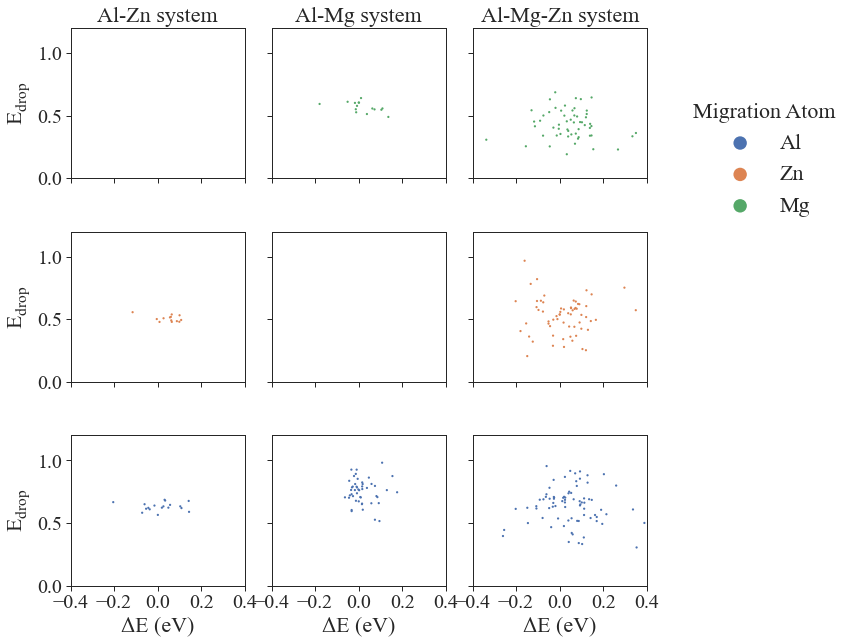

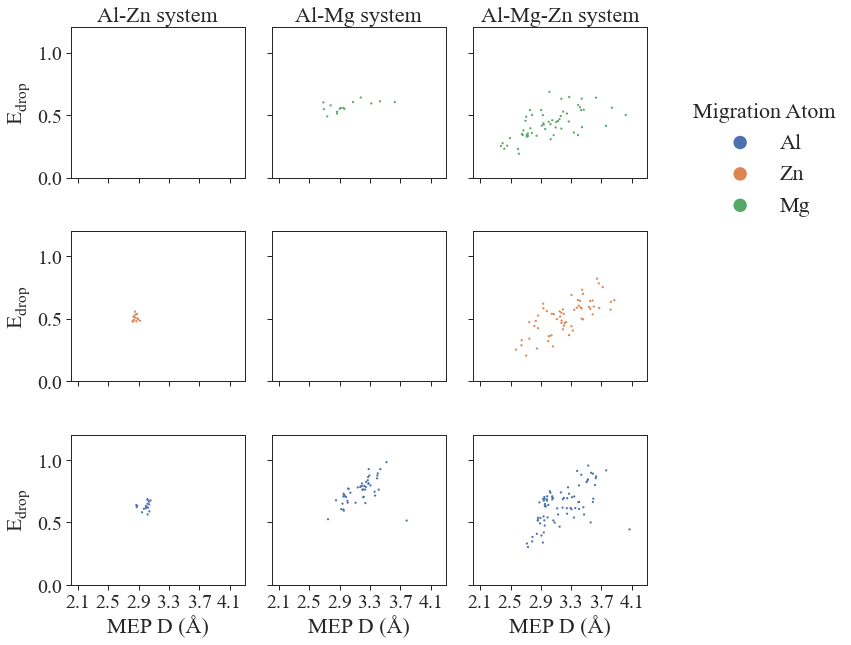

In [15]:
xlim_range = [-0.4, 0.4]
ylim_range = [0, 1.2]
sns.set(font='Times New Roman',style='ticks')
sns.set_style({"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":22,"axes.labelsize":22,"xtick.labelsize":20,"ytick.labelsize":20,}) 
palette ={"Al": "C0", "Zn": "C1", "Mg": "C2"}
g = sns.FacetGrid(df, col="migration_system", legend_out= True, row="migration_atom", hue="migration_atom",
                  hue_order=["Al","Zn","Mg"],
                  row_order=["Mg","Zn","Al"],
                  col_order=['Al-Zn', 'Al-Mg', 'Al-Mg-Zn'], margin_titles=False, sharey=True,
                  ylim=ylim_range, xlim=xlim_range, palette=palette)
marker = matplotlib.markers.MarkerStyle('o',fillstyle='full')
g = g.map_dataframe(plt.scatter, x="energy_difference", y="e_drop",  alpha=1, s=5, marker=marker, edgecolors='none')
g = g.add_legend(loc='upper center', bbox_to_anchor=(1, .85), markerscale=6, scatterpoints=1, label_order=['Al', 'Zn', 'Mg'], prop={'size':22})
g._legend.set_title('Migration Atom', prop={'size':22})

for i in range(3):
    g.axes[i,0].set_ylabel(r'$\mathregular{E_{drop}}$')

g.axes[0,0].set_title('Al-Zn system')
g.axes[0,1].set_title('Al-Mg system')
g.axes[0,2].set_title('Al-Mg-Zn system')

for i in range(1,3):
    for j in range(3):
        g.axes[i,j].set_title('')

for ax in g.axes.flatten():
    ax.set_xticks(np.arange(-0.4,0.45,0.2))
for ax in g.axes[2]:
    ax.set_xlabel('ΔE (eV)')

g.despine(top=False, right=False)
##############################################################################################################################
xlim_range = [2.0, 4.3]
ylim_range = [0, 1.2]
sns.set(font='Times New Roman',style='ticks')
sns.set_style({"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":22,"axes.labelsize":22,"xtick.labelsize":20,"ytick.labelsize":20,}) 
palette ={"Al": "C0", "Zn": "C1", "Mg": "C2"}
g = sns.FacetGrid(df, col="migration_system", legend_out= True, row="migration_atom", hue="migration_atom",
                  hue_order=["Al","Zn","Mg"],
                  row_order=["Mg","Zn","Al"],
                  col_order=['Al-Zn', 'Al-Mg', 'Al-Mg-Zn'], margin_titles=False, sharey=True,
                  ylim=ylim_range, xlim=xlim_range, palette=palette)
marker = matplotlib.markers.MarkerStyle('o',fillstyle='full')
g = g.map_dataframe(plt.scatter, x="MEP_distance", y="e_drop",  alpha=1, s=5, marker=marker, edgecolors='none')
g = g.add_legend(loc='upper center', bbox_to_anchor=(1, .85), markerscale=6, scatterpoints=1, label_order=['Al', 'Zn', 'Mg'], prop={'size':22})
g._legend.set_title('Migration Atom', prop={'size':22})

for i in range(3):
    g.axes[i,0].set_ylabel(r'$\mathregular{E_{drop}}$')

g.axes[0,0].set_title('Al-Zn system')
g.axes[0,1].set_title('Al-Mg system')
g.axes[0,2].set_title('Al-Mg-Zn system')

for i in range(1,3):
    for j in range(3):
        g.axes[i,j].set_title('')

for ax in g.axes.flatten():
    ax.set_xticks(np.arange(2.1, 4.3, 0.4))
for ax in g.axes[2]:
    ax.set_xlabel('MEP D (Å)')

g.despine(top=False, right=False)


Text(0.5, 0.98, '')

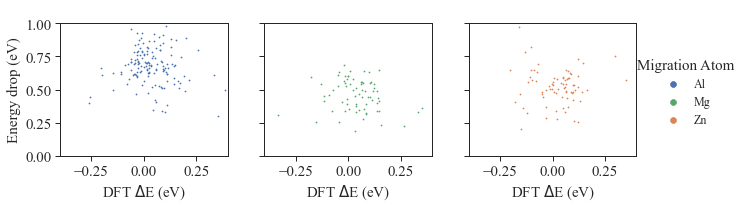

In [11]:
sns.set(font='Times New Roman', style='ticks')
sns.set_style({'xtick.major.size': 8, 'ytick.major.size': 8})
sns.set_context('paper', rc={'font.size': 12, 'axes.titlesize': 15, 'axes.labelsize': 15,
                             'xtick.labelsize': 15, 'ytick.labelsize': 15, })

xlim_range = [-0.4, 0.4]
ylim_range = [0, 1]

ele_list = ['Al', 'Mg', 'Zn']
palette = {'Al': 'C0', 'Zn': 'C1', 'Mg': 'C2'}

g = sns.FacetGrid(df, col='migration_atom', hue='migration_atom', legend_out=True,
                  col_order=ele_list, margin_titles=False,
                  ylim=ylim_range, xlim=xlim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'energy_difference', 'e_drop', alpha=1, s=1, marker='8')
g = g.add_legend(loc='upper center', bbox_to_anchor=(0.96, .75), markerscale=6,
                 scatterpoints=1, label_order=ele_list, prop={'size': 12})
g._legend.set_title('Migration Atom', prop={'size': 15})

g.axes[0, 0].set_ylabel('Energy drop (eV)')
for ax in g.axes.flat:
    ax.set_title('')
    ax.set_xlabel(xlabel='DFT $\Delta$E (eV)')
g.despine(top=False, right=False)
g.set_titles(' ')
g.fig.suptitle('', size=20)


Text(0.5, 0.98, '')

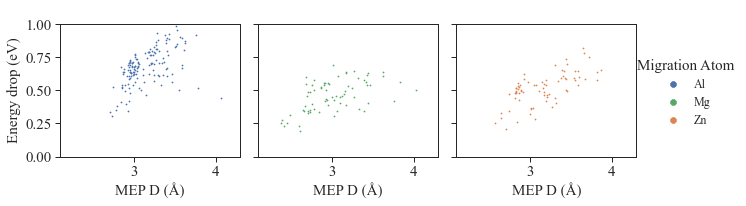

In [111]:
sns.set(font='Times New Roman', style='ticks')
sns.set_style({'xtick.major.size': 8, 'ytick.major.size': 8})
sns.set_context('paper', rc={'font.size': 12, 'axes.titlesize': 15, 'axes.labelsize': 15,
                             'xtick.labelsize': 15, 'ytick.labelsize': 15, })

xlim_range = [2.1, 4.3]
ylim_range = [0, 1]

ele_list = ['Al', 'Mg', 'Zn']
palette = {'Al': 'C0', 'Zn': 'C1', 'Mg': 'C2'}

g = sns.FacetGrid(df, col='migration_atom', hue='migration_atom', legend_out=True,
                  col_order=ele_list, margin_titles=False,
                  ylim=ylim_range, xlim=xlim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'MEP_distance', 'e_drop', alpha=1, s=1, marker='8')
g = g.add_legend(loc='upper center', bbox_to_anchor=(0.96, .75), markerscale=6,
                 scatterpoints=1, label_order=ele_list, prop={'size': 12})
g._legend.set_title('Migration Atom', prop={'size': 15})

g.axes[0, 0].set_ylabel('Energy drop (eV)')
for ax in g.axes.flat:
    ax.set_title('')
    ax.set_xlabel(xlabel='MEP D (Å)')
g.despine(top=False, right=False)
g.set_titles(' ')
g.fig.suptitle('', size=20)
